<a href="https://colab.research.google.com/github/GurashishJuneja/MMAI831-Finance/blob/main/Assignment_2_MMAI_823_Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1: Use the same companies we picked in the Session - 2 Frontier Analysis example, and the same time period (2017-2021). Risk free interest rates can be downloaded from yfinance ( using the 13 week T-bill yield, symbol is ^ IRX)

a. On the first business day of January, 2022 use the weekly data to estimate the covariance matrix for weekly returns. 

b. Use any ML tools to forecast the returns for each stocks for the first week of January of 2022. You can use the LSTM or others for the forecast. 

c. Use your estimations from a) and b) to find the portfolio with the highest Sharpe ratio, i.e, the efficient frontier portfolio. You might assume that there is no short sale (porftfolio coefficients are non negative).

d. What is your portfolio's actual rate of return for the first week of January 2022? What is the rate for an equally weighted portfolio?

Initial Setup

In [1]:
#For this question, I need to intialize the companies which have been used in the previous question

#Start with importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl
import scipy.optimize as sco
import yfinance as yf
import pandas as pd

import statsmodels.api as sm
from scipy.optimize import minimize

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

# Define the stock symbols
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each stock symbol and retrieve the data
for stock in stocks:
    # Retrieve the daily stock data for the year 2022
    stock_data = yf.download(stock, start='2017-01-01', end='2022-12-31')
       
    # Add a column for the stock symbol
    stock_data.loc[:, 'ticker'] = stock
    
    # Append the stock data to the main DataFrame
    data = pd.concat([data, stock_data], axis=0)

# Reset the index of the DataFrame
data.reset_index(inplace=True)

# Select the desired columns
data = data[['Date', 'ticker', 'Adj Close']]

# Rename the columns to match the original code
data.columns = ['date', 'ticker', 'adj_close']

# Print the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        date ticker  adj_close
0 2017-01-03   AAPL  27.095850
1 2017-01-04   AAPL  27.065519
2 2017-01-05   AAPL  27.203156
3 2017-01-06   AAPL  27.506430
4 2017-01-09   AAPL  27.758371


In [4]:
#Installing IRX T-bill

# Define the start and end dates
start_date = '2017-01-01'
end_date = '2022-12-31'

# Download the risk-free interest rate data
risk_free_data = yf.download('^IRX', start=start_date, end=end_date)

# Print the downloaded data
print(risk_free_data)

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2017-01-03  0.488  0.490  0.475  0.475      0.475       0
2017-01-04  0.518  0.520  0.518  0.518      0.518       0
2017-01-05  0.510  0.510  0.503  0.508      0.508       0
2017-01-06  0.503  0.508  0.500  0.503      0.503       0
2017-01-09  0.500  0.500  0.483  0.485      0.485       0
...           ...    ...    ...    ...        ...     ...
2022-12-23  4.195  4.208  4.183  4.193      4.193       0
2022-12-27  4.198  4.223  4.153  4.195      4.195       0
2022-12-28  4.338  4.343  4.328  4.338      4.338       0
2022-12-29  4.333  4.333  4.295  4.295      4.295       0
2022-12-30  4.298  4.300  4.223  4.260      4.260       0

[1510 rows x 6 columns]


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12080 entries, 0 to 12079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       12080 non-null  datetime64[ns]
 1   ticker     12080 non-null  object        
 2   adj_close  12080 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 283.2+ KB


In [6]:

# Check if all the companies and time period are correctly selected  
print('The companies are:', data.ticker.unique(), 'and there is', len(data),'date entry points')
print('The date range of stock data is from', data.date.min(), ' to ',data.date.max())

The companies are: ['AAPL' 'AMZN' 'GOOGL' 'BAC' 'MCD' 'CAT' 'TSLA' 'PFE'] and there is 12080 date entry points
The date range of stock data is from 2017-01-03 00:00:00  to  2022-12-30 00:00:00


In [7]:

# keep this 'data' as original and use df. We drop the level(0), which is the adj_closed written on th first line, no need for it
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = table.columns.droplevel(0)
table.head()

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
date,,,,,,,,
2017-01-03,27.095850,37.683498,19.599295,79.812836,40.400501,102.466888,24.618332,14.466000
2017-01-04,27.065519,37.859001,19.964657,79.456184,40.388500,102.346947,24.834673,15.132667
2017-01-05,27.203156,39.022499,19.729780,78.972137,40.651001,102.535400,25.073397,15.116667
2017-01-06,27.506430,39.799500,19.729780,79.006142,41.260502,103.443398,24.976418,15.267333
2017-01-09,27.758371,39.846001,19.616688,78.437157,41.359001,103.160721,24.968952,15.418667


Text(0, 0.5, 'price in $')

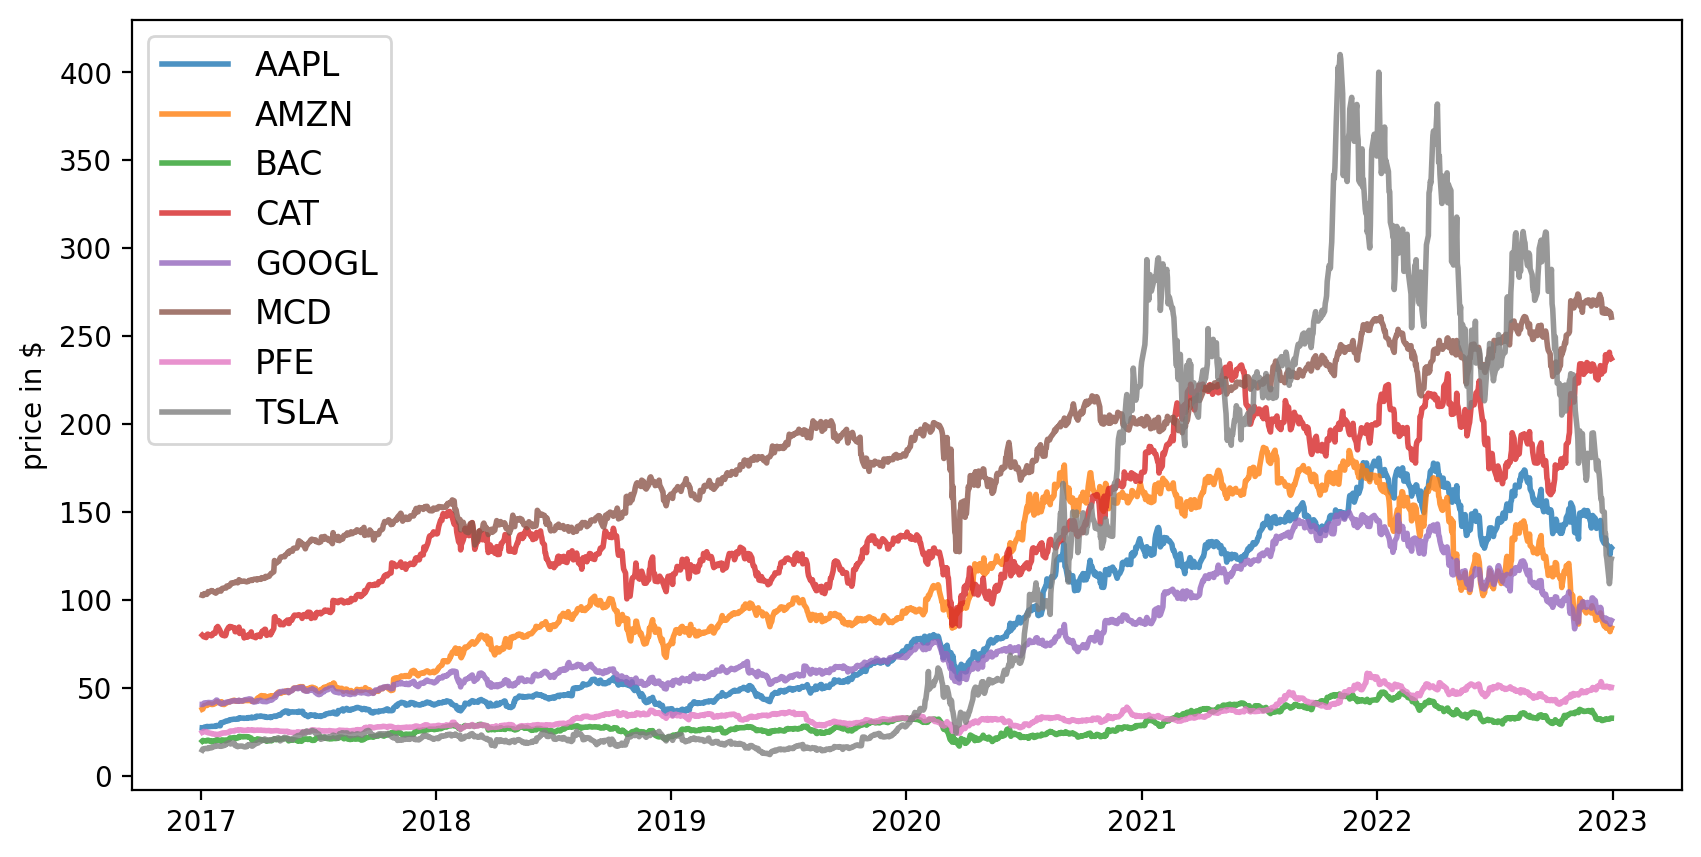

In [9]:
plt.figure(figsize=(10, 5))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

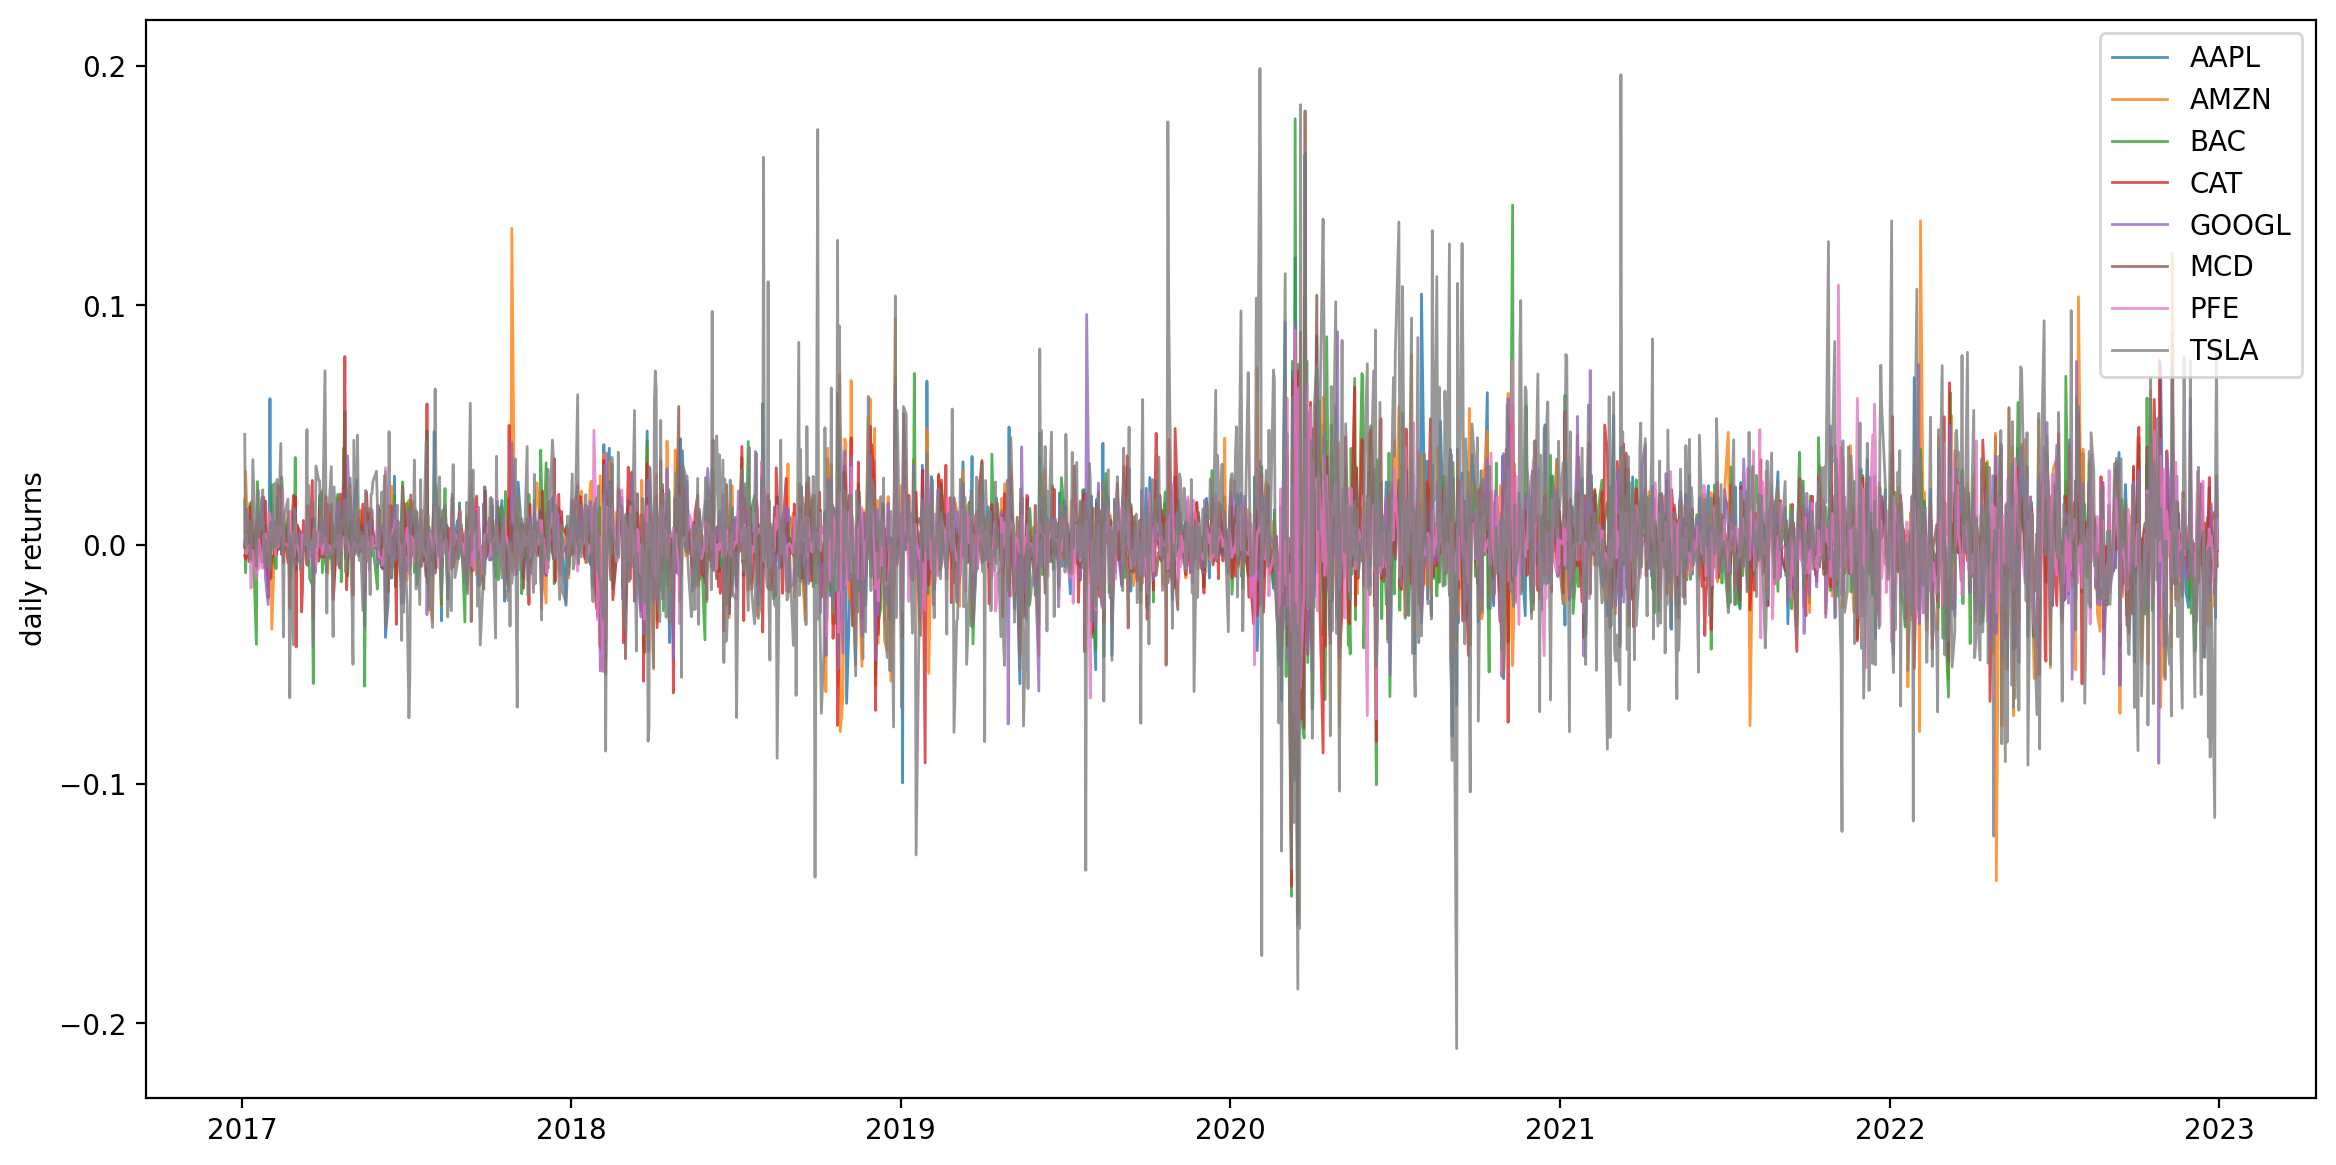

In [13]:
# Calculate the daily percentage returns of the table and then plot the daily returns for each column
# Need daily returns for corelation analysis
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=10)
plt.ylabel('daily returns')
     

In [14]:
#Estimate the inputs needed for the MV Analysis
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 2500 # number of random portfolios


a. On the first business day of January, 2022 use the weekly data to estimate the covariance matrix for weekly returns.

In [17]:
#assuming the first day of the year

first_day_2022 = "2022-01-01"

#selecting the weekly data

weekly_returns_2022 = returns.loc[first_day_2022:].resample("W").last()

#estimating the covariance matrix

cov_matrix_2022 = weekly_returns_2022.cov()

#Printing the covariance matrix for a weekly return in 2022

print(cov_matrix_2022)

ticker      AAPL      AMZN       BAC       CAT     GOOGL       MCD       PFE  \
ticker                                                                         
AAPL    0.000626  0.000550  0.000295  0.000223  0.000507  0.000225  0.000234   
AMZN    0.000550  0.001760  0.000547  0.000359  0.000598  0.000169  0.000210   
BAC     0.000295  0.000547  0.000440  0.000253  0.000302  0.000122  0.000162   
CAT     0.000223  0.000359  0.000253  0.000630  0.000317  0.000094  0.000197   
GOOGL   0.000507  0.000598  0.000302  0.000317  0.000590  0.000183  0.000211   
MCD     0.000225  0.000169  0.000122  0.000094  0.000183  0.000179  0.000180   
PFE     0.000234  0.000210  0.000162  0.000197  0.000211  0.000180  0.000353   
TSLA    0.000639  0.000907  0.000292  0.000278  0.000568  0.000148  0.000161   

ticker      TSLA  
ticker            
AAPL    0.000639  
AMZN    0.000907  
BAC     0.000292  
CAT     0.000278  
GOOGL   0.000568  
MCD     0.000148  
PFE     0.000161  
TSLA    0.001405  


b. Use any ML tools to forecast the returns for each stocks for the first week of January of 2022. You can use the LSTM or others for the forecast.

In [45]:
# Step 1: Prepare the data
train_data = returns.loc[:'2021-12-31']
test_data = returns.loc[pd.to_datetime('2022-01-01'):]  # Convert the date to datetime type

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))  # Reshape the array

# Prepare the training data
X_train = []
y_train = []
for i in range(10, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-10:i, 0])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to have a third dimension (number of features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Step 2: Design and train the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
315/315 [==============================] - 10s 15ms/step - loss: nan
Epoch 2/10
315/315 [==============================] - 6s 18ms/step - loss: nan
Epoch 3/10
315/315 [==============================] - 5s 15ms/step - loss: nan
Epoch 4/10
315/315 [==============================] - 5s 15ms/step - loss: nan
Epoch 5/10
315/315 [==============================] - 6s 18ms/step - loss: nan
Epoch 6/10
315/315 [==============================] - 5s 14ms/step - loss: nan
Epoch 7/10
315/315 [==============================] - 5s 17ms/step - loss: nan
Epoch 8/10
315/315 [==============================] - 6s 18ms/step - loss: nan
Epoch 9/10
315/315 [==============================] - 5s 17ms/step - loss: nan
Epoch 10/10
315/315 [==============================] - 6s 20ms/step - loss: nan


In [54]:
# Step 3: Make predictions for the first week of January 2022

inputs = test_data[:10].values.reshape(-1, 1)  # Reshape the array and select the first 10 trading days

inputs_scaled = scaler.transform(inputs)  # Scale the inputs

X_test = inputs_scaled.reshape(1, 10, 1)  # Adjust the input shape to (1, 10, 1)

predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(predictions_scaled)

# Print the predicted returns for the first week of January 2022

print(predictions)

ValueError: ignored

In [57]:
# Step 3: Make predictions for the first week of January 2022
inputs = test_data[:10].values.reshape(1, 10, 1)  # Reshape the array to match the expected shape
inputs_scaled = scaler.transform(inputs)  # Scale the inputs

predictions_scaled = model.predict(inputs_scaled)
predictions = scaler.inverse_transform(predictions_scaled)

# Print the predicted returns for the first week of January 2022
print(predictions)



ValueError: ignored